In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta as ta
import warnings
warnings.filterwarnings("ignore")

In [2]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].replace('\.','-',regex=True)
symbols_list = sp500['Symbol'].unique().tolist()

In [3]:
end_date = "2023-09-01"
start_date = pd.to_datetime(end_date) - pd.DateOffset(years=7)

In [4]:

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df.head()

[*********************100%***********************]  503 of 503 completed

1 Failed download:
- VLTO: Data doesn't exist for startDate = 1472673600, endDate = 1693512000


adj close      close       high        low  \
date                ticker                                               
2016-08-31 00:00:00 A       44.348038  46.980000  47.189999  46.810001   
                    AAL     34.989563  36.299999  36.980000  35.630001   
                    AAPL    24.559357  26.525000  26.642500  26.410000   
                    ABBV    46.695347  64.099998  64.449997  63.500000   
                    ABT     36.849171  42.020000  42.980000  41.930000   

                                 open       volume  
date                ticker                          
2016-08-31 00:00:00 A       47.119999    1676600.0  
                    AAL     36.970001   13111700.0  
                    AAPL    26.415001  118649600.0  
                    ABBV    64.209999    6750000.0  
                    ABT     42.869999   12445800.0

In [10]:
df.index.names = ['Date','Ticker']
df.columns = df.columns.str.lower()
df.head()

adj close      close  ...       open       volume
Date                Ticker                        ...                        
2016-08-31 00:00:00 A       44.348042  46.980000  ...  47.119999    1676600.0
                    AAL     34.989559  36.299999  ...  36.970001   13111700.0
                    AAPL    24.559357  26.525000  ...  26.415001  118649600.0
                    ABBV    46.695339  64.099998  ...  64.209999    6750000.0
                    ABT     36.849182  42.020000  ...  42.869999   12445800.0

[5 rows x 6 columns]

In [5]:
# Garman Klass Volatility

df['garman_klass_vol'] = ((np.log(df['high']) - np.log(df['low']))**2 / 2 - (2 * np.log(2) - 1) * (np.log(df['adj close']) - np.log(df['open']))**2)
df.head()

adj close      close       high        low  \
date                ticker                                               
2016-08-31 00:00:00 A       44.348038  46.980000  47.189999  46.810001   
                    AAL     34.989563  36.299999  36.980000  35.630001   
                    AAPL    24.559357  26.525000  26.642500  26.410000   
                    ABBV    46.695347  64.099998  64.449997  63.500000   
                    ABT     36.849171  42.020000  42.980000  41.930000   

                                 open       volume  garman_klass_vol  
date                ticker                                            
2016-08-31 00:00:00 A       47.119999    1676600.0         -0.001387  
                    AAL     36.970001   13111700.0         -0.000479  
                    AAPL    26.415001  118649600.0         -0.002011  
                    ABBV    64.209999    6750000.0         -0.039080  
                    ABT     42.869999   12445800.0         -0.008542

In [7]:
# RSI
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.rsi(close= x, length=20))
df.tail()

adj close       close        high         low  \
date                ticker                                                   
2023-08-31 00:00:00 YUM     128.770905  129.380005  130.820007  129.380005   
                    ZBH     118.861885  119.120003  121.089996  119.120003   
                    ZBRA    275.010010  275.010010  279.880005  274.769989   
                    ZION     35.073166   35.500000   35.540001   34.860001   
                    ZTS     190.054947  190.509995  193.279999  190.470001   

                                  open     volume  garman_klass_vol        rsi  
date                ticker                                                      
2023-08-31 00:00:00 YUM     130.139999  1465300.0          0.000018  41.284870  
                    ZBH     120.629997  2746000.0          0.000050  35.413090  
                    ZBRA    279.880005   372800.0          0.000051  50.000885  
                    ZION     35.080002  2110000.0          0.000187  54.234127  
                    ZTS     192.259995  1893000.0          0.000056  59.041348

<AxesSubplot:xlabel='date'>

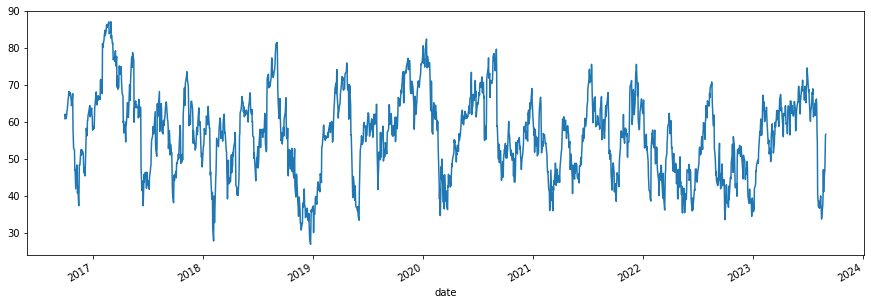

In [8]:
df.xs('AAPL', level=1)['rsi'].plot(figsize=(15,5))

<AxesSubplot:xlabel='date'>

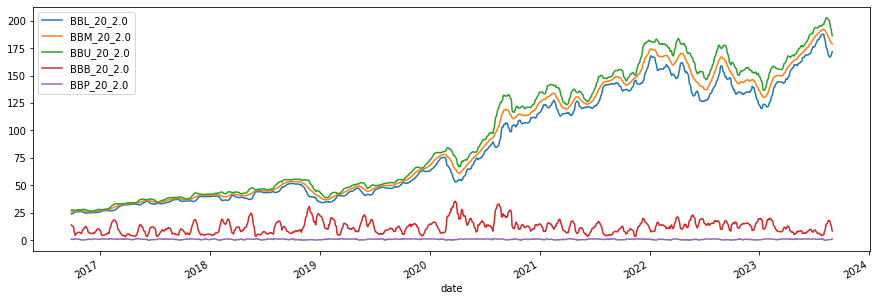

In [9]:
# Bolinger Bands
ta.bbands(df.xs('AAPL', level=1)['adj close'], length=20, std=2, append=True).plot(figsize=(15,5))

In [10]:
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.bbands(close= np.log(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.bbands(close= np.log(x), length=20).iloc[:,1])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.bbands(close= np.log(x), length=20).iloc[:,2])

In [13]:
# ATR

def compute_atr(stock_data):
    atr = ta.atr(high=stock_data['high'], low=stock_data['low'], close=stock_data['adj close'], length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys = False).apply(compute_atr)
df.tail()

adj close       close        high         low  \
date                ticker                                                   
2023-08-31 00:00:00 YUM     128.770905  129.380005  130.820007  129.380005   
                    ZBH     118.861885  119.120003  121.089996  119.120003   
                    ZBRA    275.010010  275.010010  279.880005  274.769989   
                    ZION     35.073166   35.500000   35.540001   34.860001   
                    ZTS     190.054947  190.509995  193.279999  190.470001   

                                  open     volume  garman_klass_vol  \
date                ticker                                            
2023-08-31 00:00:00 YUM     130.139999  1465300.0          0.000018   
                    ZBH     120.629997  2746000.0          0.000050   
                    ZBRA    279.880005   372800.0          0.000051   
                    ZION     35.080002  2110000.0          0.000187   
                    ZTS     192.259995  1893000.0          0.000056   

                                  rsi    bb_low    bb_mid   bb_high       atr  
date                ticker                                                     
2023-08-31 00:00:00 YUM     41.284870  4.835881  4.869701  4.903520 -2.468486  
                    ZBH     35.413090  4.727943  4.790347  4.852750 -1.922438  
                    ZBRA    50.000885  5.519345  5.579874  5.640404  0.068570  
                    ZION    54.234127  3.481500  3.560479  3.639459 -2.257639  
                    ZTS     59.041348  5.176585  5.223492  5.270398 -0.423032

In [14]:
# MACD

def compute_macd(close):
    macd = ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys = False)['adj close'].apply(compute_macd)
df.tail()

adj close       close        high         low  \
date                ticker                                                   
2023-08-31 00:00:00 YUM     128.770905  129.380005  130.820007  129.380005   
                    ZBH     118.861885  119.120003  121.089996  119.120003   
                    ZBRA    275.010010  275.010010  279.880005  274.769989   
                    ZION     35.073166   35.500000   35.540001   34.860001   
                    ZTS     190.054947  190.509995  193.279999  190.470001   

                                  open     volume  garman_klass_vol  \
date                ticker                                            
2023-08-31 00:00:00 YUM     130.139999  1465300.0          0.000018   
                    ZBH     120.629997  2746000.0          0.000050   
                    ZBRA    279.880005   372800.0          0.000051   
                    ZION     35.080002  2110000.0          0.000187   
                    ZTS     192.259995  1893000.0          0.000056   

                                  rsi    bb_low    bb_mid   bb_high       atr  \
date                ticker                                                      
2023-08-31 00:00:00 YUM     41.284870  4.835881  4.869701  4.903520 -2.468486   
                    ZBH     35.413090  4.727943  4.790347  4.852750 -1.922438   
                    ZBRA    50.000885  5.519345  5.579874  5.640404  0.068570   
                    ZION    54.234127  3.481500  3.560479  3.639459 -2.257639   
                    ZTS     59.041348  5.176585  5.223492  5.270398 -0.423032   

                                macd  
date                ticker            
2023-08-31 00:00:00 YUM    -1.196816  
                    ZBH    -1.729893  
                    ZBRA   -0.295564  
                    ZION    0.088588  
                    ZTS     0.783013

In [15]:
df['dollar_volume'] = df['adj close'] * df['volume']/1e6
df.tail()

adj close       close        high         low  \
date                ticker                                                   
2023-08-31 00:00:00 YUM     128.770905  129.380005  130.820007  129.380005   
                    ZBH     118.861885  119.120003  121.089996  119.120003   
                    ZBRA    275.010010  275.010010  279.880005  274.769989   
                    ZION     35.073166   35.500000   35.540001   34.860001   
                    ZTS     190.054947  190.509995  193.279999  190.470001   

                                  open     volume  garman_klass_vol  \
date                ticker                                            
2023-08-31 00:00:00 YUM     130.139999  1465300.0          0.000018   
                    ZBH     120.629997  2746000.0          0.000050   
                    ZBRA    279.880005   372800.0          0.000051   
                    ZION     35.080002  2110000.0          0.000187   
                    ZTS     192.259995  1893000.0          0.000056   

                                  rsi    bb_low    bb_mid   bb_high       atr  \
date                ticker                                                      
2023-08-31 00:00:00 YUM     41.284870  4.835881  4.869701  4.903520 -2.468486   
                    ZBH     35.413090  4.727943  4.790347  4.852750 -1.922438   
                    ZBRA    50.000885  5.519345  5.579874  5.640404  0.068570   
                    ZION    54.234127  3.481500  3.560479  3.639459 -2.257639   
                    ZTS     59.041348  5.176585  5.223492  5.270398 -0.423032   

                                macd  dollar_volume  
date                ticker                           
2023-08-31 00:00:00 YUM    -1.196816     188.688006  
                    ZBH    -1.729893     326.394736  
                    ZBRA   -0.295564     102.523732  
                    ZION    0.088588      74.004380  
                    ZTS     0.783013     359.774014

In [45]:
# Convert 'date' index to datetime if it's not
df.index = df.index.set_levels([pd.to_datetime(df.index.levels[0]), df.index.levels[1]])

last_cols = [c for c in df.columns if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]

data = (pd.concat([df['dollar_volume'].unstack('ticker').resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df[last_cols].unstack('ticker').resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2016-10-31 A           76.157551   41.231243 -1.292594  3.822555  3.699111   
           AAL        317.077358   39.134331  1.430436  3.681468  3.577124   
           AAPL      3507.856055   26.281528 -0.997160  3.319001  3.259075   
           ABBV       282.324741   41.009075  0.404553  3.859384  3.748525   
           ABT        322.751508   34.630032 -0.211188  3.639177  3.535428   
...                          ...         ...       ...       ...       ...   
2023-08-31 OTIS       150.106325   85.202072 -1.976208  4.490886  4.399571   
           ABNB       633.134438  131.550003 -1.075852  4.959263  4.793749   
           CEG        176.642431  103.919220 -1.233819  4.678925  4.634536   
           GEHC       188.526393   70.417595 -1.268386  4.324489  4.195419   
           KVUE      1697.927750   22.811756 -1.485127  3.153434  3.103367   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2016-10-31 A       3.760833         -0.000881 -0.543644  36.889481  
           AAL     3.629296         -0.000176  1.048349  61.313771  
           AAPL    3.289038         -0.002307 -0.214725  52.321930  
           ABBV    3.803955         -0.041756 -0.705943  27.788562  
           ABT     3.587302         -0.006476 -0.590599  38.506631  
...                     ...               ...       ...        ...  
2023-08-31 OTIS    4.445228          0.000055 -0.996851  48.192564  
           ABNB    4.876506          0.000181 -0.477455  48.633358  
           CEG     4.656730          0.000100  0.514367  58.644605  
           GEHC    4.259954          0.000161 -1.575309  37.744736  
           KVUE    3.128401          0.000039  0.221793  42.846916  

[41097 rows x 9 columns]

In [40]:
df.columns

Index(['adj close', 'close', 'high', 'low', 'open', 'volume',
       'garman_klass_vol', 'rsi', 'bb_low', 'bb_mid', 'bb_high', 'atr', 'macd',
       'dollar_volume'],
      dtype='object')

In [46]:
# Calculating the 5 year rolling average for each stock before filtering

data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-09-30 AAL      46.185772  1.229921  3.855353  3.740826  3.798089   
           AAPL     36.304008 -0.788049  3.663088  3.564932  3.614010   
           ABBV     67.243988  1.239370  4.268000  4.060900  4.164450   
           ABT      47.949158  0.168770  3.871578  3.818798  3.845188   
           ACN     122.512245  0.580703  4.845423  4.773818  4.809620   
...                       ...       ...       ...       ...       ...   
2023-08-31 WFC      40.925156 -1.424579  3.800851  3.689343  3.745097   
           WMT     162.008286 -2.289429  5.086798  5.044459  5.065629   
           XOM     110.182457 -1.357793  4.708366  4.648635  4.678500   
           MRNA    113.070000 -0.491808  4.799730  4.544455  4.672092   
           ABNB    131.550003 -1.075852  4.959263  4.793749  4.876506   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2017-09-30 AAL            -0.000215  0.354333  53.050768  
           AAPL           -0.001012 -0.474056  45.768842  
           ABBV           -0.029421  1.201413  70.568532  
           ABT            -0.004815  0.335034  63.664988  
           ACN            -0.004568  0.170253  56.250068  
...                             ...       ...        ...  
2023-08-31 WFC            -0.000024 -0.761258  40.379118  
           WMT             0.000067  0.280243  62.863829  
           XOM            -0.000002  0.805548  59.213664  
           MRNA            0.000198 -0.044047  49.504327  
           ABNB            0.000181 -0.477455  48.633358  

[10728 rows x 8 columns]

In [47]:
def calculate_returns(df):
    df.head()
    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data.tail()

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2023-08-31 WFC      40.925156 -1.424579  3.800851  3.689343  3.745097   
           WMT     162.008286 -2.289429  5.086798  5.044459  5.065629   
           XOM     110.182457 -1.357793  4.708366  4.648635  4.678500   
           MRNA    113.070000 -0.491808  4.799730  4.544455  4.672092   
           ABNB    131.550003 -1.075852  4.959263  4.793749  4.876506   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2023-08-31 WFC            -0.000024 -0.761258  40.379118  -0.098507   
           WMT             0.000067  0.280243  62.863829   0.020819   
           XOM            -0.000002  0.805548  59.213664   0.045333   
           MRNA            0.000198 -0.044047  49.504327  -0.039011   
           ABNB            0.000181 -0.477455  48.633358  -0.135620   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2023-08-31 WFC     -0.012580   0.014874  -0.018009  -0.014077   -0.002380  
           WMT      0.018933   0.035742   0.024639   0.008918    0.018467  
           XOM      0.022367   0.031372   0.004742   0.002572    0.015423  
           MRNA    -0.035315  -0.039772  -0.033606  -0.047921   -0.012985  
           ABNB     0.013139   0.062190   0.010880   0.028515    0.012658

In [48]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-09-30 AAL     0.0006 -0.0248 -0.0170  0.0063  0.0129   0.020998
           AAPL    0.0006 -0.0248 -0.0170  0.0063  0.0129  -0.008303
           ABBV    0.0006 -0.0248 -0.0170  0.0063  0.0129  -0.014587
           ABT     0.0006 -0.0248 -0.0170  0.0063  0.0129   0.097546
           ACN     0.0006 -0.0248 -0.0170  0.0063  0.0129   0.006684
...                   ...     ...     ...     ...     ...        ...
2023-08-31 VRTX   -0.0239 -0.0365 -0.0106  0.0343 -0.0237  -0.011353
           VZ     -0.0239 -0.0365 -0.0106  0.0343 -0.0237   0.026408
           WFC    -0.0239 -0.0365 -0.0106  0.0343 -0.0237  -0.098507
           WMT    -0.0239 -0.0365 -0.0106  0.0343 -0.0237   0.020819
           XOM    -0.0239 -0.0365 -0.0106  0.0343 -0.0237   0.045333

[8652 rows x 6 columns]

In [49]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-09-30 AAL     0.0006 -0.0248 -0.0170  0.0063  0.0129   0.020998
           AAPL    0.0006 -0.0248 -0.0170  0.0063  0.0129  -0.008303
           ABBV    0.0006 -0.0248 -0.0170  0.0063  0.0129  -0.014587
           ABT     0.0006 -0.0248 -0.0170  0.0063  0.0129   0.097546
           ACN     0.0006 -0.0248 -0.0170  0.0063  0.0129   0.006684
...                   ...     ...     ...     ...     ...        ...
2023-08-31 VRTX   -0.0239 -0.0365 -0.0106  0.0343 -0.0237  -0.011353
           VZ     -0.0239 -0.0365 -0.0106  0.0343 -0.0237   0.026408
           WFC    -0.0239 -0.0365 -0.0106  0.0343 -0.0237  -0.098507
           WMT    -0.0239 -0.0365 -0.0106  0.0343 -0.0237   0.020819
           XOM    -0.0239 -0.0365 -0.0106  0.0343 -0.0237   0.045333

[8624 rows x 6 columns]

In [50]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))


betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-09-30 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-08-31 VRTX    0.504997 -0.410859 -0.481616  0.057667  0.943949
           VZ      0.301765 -0.207739  0.330172  0.318135  0.011684
           WFC     1.137639  0.314484  2.009072 -0.404336 -1.468838
           WMT     0.740051 -0.261864 -0.522765 -0.126428  0.642693
           XOM     1.008084 -1.047878  1.707670 -0.674214 -0.280497

[8624 rows x 5 columns]

In [51]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8490 entries, (Timestamp('2018-09-30 00:00:00'), 'AAL') to (Timestamp('2023-08-31 00:00:00'), 'MRNA')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               8490 non-null   float64
 1   bb_high           8490 non-null   float64
 2   bb_low            8490 non-null   float64
 3   bb_mid            8490 non-null   float64
 4   garman_klass_vol  8490 non-null   float64
 5   macd              8490 non-null   float64
 6   rsi               8490 non-null   float64
 7   return_1m         8490 non-null   float64
 8   return_2m         8490 non-null   float64
 9   return_3m         8490 non-null   float64
 10  return_6m         8490 non-null   float64
 11  return_9m         8490 non-null   float64
 12  return_12m        8490 non-null   float64
 13  Mkt-RF            8490 non-null   float64
 14  SMB               8490 non-null   float64
 15  HML        

In [54]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init='random').fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-09-30 AAL     0.509027  3.743816  3.622192  3.683004          0.000314   
           AAPL   -0.283626  4.003763  3.942932  3.973347         -0.000594   
           ABBV    1.255649  4.326576  4.271411  4.298994         -0.021787   
           ABT     0.672743  4.211335  4.071416  4.141375         -0.002414   
           ACN     0.845020  5.083606  5.043362  5.063484         -0.002293   
...                     ...       ...       ...       ...               ...   
2023-08-31 VZ     -2.145066  3.525316  3.446528  3.485922         -0.000058   
           WFC    -1.424579  3.800851  3.689343  3.745097         -0.000024   
           WMT    -2.289429  5.086798  5.044459  5.065629          0.000067   
           XOM    -1.357793  4.708366  4.648635  4.678500         -0.000002   
           MRNA   -0.491808  4.799730  4.544455  4.672092          0.000198   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-09-30 AAL     0.858641  54.647866   0.020998   0.023718   0.029652   
           AAPL   -0.030668  61.186147  -0.008303   0.091080   0.069629   
           ABBV   -0.450259  49.718882  -0.014587   0.012660   0.010312   
           ABT     1.203591  79.127181   0.097546   0.057977   0.065081   
           ACN     0.137462  54.490777   0.006684   0.033549   0.013291   
...                     ...        ...        ...        ...        ...   
2023-08-31 VZ      0.320914  59.357846   0.026408  -0.021525  -0.000223   
           WFC    -0.761258  40.379118  -0.098507  -0.012580   0.014874   
           WMT     0.280243  62.863829   0.020819   0.018933   0.035742   
           XOM     0.805548  59.213664   0.045333   0.022367   0.031372   
           MRNA   -0.044047  49.504327  -0.039011  -0.035315  -0.039772   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-09-30 AAL     -0.036636  -0.024513   -0.010765  1.097396  1.705801   
           AAPL     0.051986   0.033843    0.033607  1.338308 -0.397164   
           ABBV     0.003293   0.000594    0.008112  0.548221  0.523970   
           ABT      0.035905   0.029900    0.028503  0.782155 -0.138918   
           ACN      0.018852   0.012830    0.021018  1.219508 -0.146681   
...                      ...        ...         ...       ...       ...   
2023-08-31 VZ      -0.011557  -0.006481   -0.009281  0.328722 -0.075930   
           WFC     -0.018009  -0.014077   -0.002380  1.065858  0.205871   
           WMT      0.024639   0.008918    0.018467  0.774946 -0.182837   
           XOM      0.004742   0.002572    0.015423  0.989673 -0.745730   
           MRNA    -0.033606  -0.047921   -0.012985  1.226022  0.756734   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-09-30 AAL     0.528665  0.555878  0.826631        0  
           AAPL   -0.706609  0.488558  0.819702        0  
           ABBV   -0.198672  0.546015  0.395139        3  
           ABT    -0.469143  0.233477  0.939801        2  
           ACN    -0.264546  0.428141  0.120558        0  
...                     ...       ...       ...      ...  
2023-08-31 VZ      0.228541  0.259960  0.190291        3  
           WFC     2.082210 -0.248116 -1.629734        1  
           WMT    -0.579690 -0.202229  0.754964        0  
           XOM     1.457532 -0.632360  0.106730        3  
           MRNA   -1.145863  0.435835  1.005074        2  

[8490 rows x 19 columns]

In [55]:
"""
 For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
 First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.
"""
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates



{'2018-10-01': ['ABBV',
  'ADI',
  'AIG',
  'AMT',
  'AXP',
  'C',
  'CMCSA',
  'EA',
  'EXPE',
  'FCX',
  'FDX',
  'GOOG',
  'GOOGL',
  'HAL',
  'INTC',
  'JPM',
  'KR',
  'MDLZ',
  'MGM',
  'MO',
  'NEE',
  'PANW',
  'PEP',
  'PG',
  'PYPL',
  'SHW',
  'TXN',
  'USB',
  'VLO',
  'VZ',
  'WMT'],
 '2018-11-01': ['AAL',
  'AAPL',
  'ABT',
  'ADBE',
  'ADP',
  'BA',
  'BKNG',
  'CHTR',
  'CMG',
  'COST',
  'CSCO',
  'DAL',
  'DIS',
  'DLTR',
  'ELV',
  'EXPE',
  'GS',
  'INTC',
  'ISRG',
  'JPM',
  'LLY',
  'MDLZ',
  'MGM',
  'MS',
  'MSFT',
  'NEE',
  'ORCL',
  'PEP',
  'PFE',
  'PNC',
  'PYPL',
  'TGT',
  'TJX',
  'TMO',
  'TMUS',
  'UAL',
  'ULTA',
  'UNH',
  'USB',
  'V',
  'WFC'],
 '2018-12-01': ['ACN',
  'ADBE',
  'ADI',
  'ADP',
  'ADSK',
  'AMAT',
  'AMZN',
  'AVGO',
  'AZO',
  'BA',
  'BAC',
  'BIIB',
  'BKNG',
  'BLK',
  'BRK-B',
  'CAT',
  'CHTR',
  'CMG',
  'COST',
  'CRM',
  'CSCO',
  'CSX',
  'CVX',
  'DG',
  'DIS',
  'DLTR',
  'EBAY',
  'EXPE',
  'F',
  'FCX',
  'FDX',
  '

In [59]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [60]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%***********************]  153 of 153 completed


Adj Close                                                  \
                  AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-09-29  46.185764   36.304005   67.243988   47.949165  122.512245   
2017-10-02  46.419178   36.230980   68.401787   48.236713  122.847862   
2017-10-03  49.122837   36.388813   67.879654   48.299603  121.768494   
2017-10-04  49.336784   36.153236   68.031029   48.829781  122.593872   
2017-10-05  49.171452   36.603168   68.242882   49.350967  123.555321   
...               ...         ...         ...         ...         ...   
2023-08-24  14.570000  176.147934  145.176865  103.178833  312.842499   
2023-08-25  14.580000  178.375000  145.236267  103.636299  317.443420   
2023-08-28  14.730000  179.952927  145.968918  102.224121  319.584534   
2023-08-29  14.900000  183.877747  146.127335  103.298180  322.114044   
2023-08-30  14.770000  187.403107  146.850113  103.835205  321.914856   

                                                                       ...  \
                  ADBE         ADI         ADP        ADSK        AIG  ...   
Date                                                                   ...   
2017-09-29  149.179993   76.404419   95.904190  112.260002  52.044823  ...   
2017-10-02  147.940002   76.094070   95.904190  112.470001  52.443272  ...   
2017-10-03  148.600006   76.165016   97.123604  113.629997  52.248280  ...   
2017-10-04  147.949997   77.140335   97.728935  114.050003  52.205894  ...   
2017-10-05  150.250000   77.929482   99.632660  116.540001  52.544998  ...   
...                ...         ...         ...         ...        ...  ...   
2023-08-24  512.429993  172.057571  247.058578  208.600006  57.745197  ...   
2023-08-25  525.059998  176.485565  250.272919  215.919998  57.506618  ...   
2023-08-28  529.919983  178.635178  251.598221  217.089996  57.526501  ...   
2023-08-29  540.570007  180.844208  251.558655  219.399994  58.003651  ...   
2023-08-30  545.359985  179.863525  252.132278  221.550003  57.993713  ...   

             Volume                                                           \
                  V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                           
2017-09-29  7676300  4442200  1500200  13021700   5323100  3733200  20872300   
2017-10-02  4885600  3141300  2057700   9525800   5513900  7502300  11764400   
2017-10-03  4411100  3194700   995000  10218600   4934300  4576500  17405100   
2017-10-04  4146800  2669900   970200   9887500   4652600  3414300  14697800   
2017-10-05  4396100  4923400  1273700  12230600   4622700  5481400  14560700   
...             ...      ...      ...       ...       ...      ...       ...   
2023-08-24  4570700  2764700   704400  18561400  13169200  1922800  10363300   
2023-08-25  3541500  5167200   697900  14912100  10937800  2659600  12534700   
2023-08-28  3741500  2680100   552500  16050400   8282300  4268500  10314500   
2023-08-29  3975600  3041800   882600  28782800   6892600  2310600  14404800   
2023-08-30  4573300  3167900   640500  15021400   5883700  3508800  12536300   

                                         
                 WMT     WYNN       XOM  
Date                                     
2017-09-29  10353400  3215000   9944000  
2017-10-02   7709200  3006000   6777900  
2017-10-03   7936700  1709000   6082000  
2017-10-04   6173400  1525000   6357100  
2017-10-05   5138700  1718500   7375900  
...              ...      ...       ...  
2023-08-24   4677700  1494000  10818500  
2023-08-25   4089000  1706200  13579300  
2023-08-28   3957000  1209800  10382100  
2023-08-29   4234100  1082900   9665000  
2023-08-30   3655900  1263500  11922100  

[1489 rows x 918 columns]

In [61]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2018-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-12-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-10-01, Continuing with Equal-Weights

,Strategy Return
date,
2018-10-01,-0.002335
2018-10-02,0.003460
2018-10-03,0.001359
2018-10-04,-0.009194
2018-10-05,-0.007130
...,...
2023-08-24,-0.014690
2023-08-25,0.007455
2023-08-28,0.005158


In [62]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%***********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2018-10-01,-0.002335,0.003468
2018-10-02,0.003460,-0.000583
2018-10-03,0.001359,0.000549
2018-10-04,-0.009194,-0.007846
2018-10-05,-0.007130,-0.005613
...,...,...
2023-08-24,-0.014690,-0.013956
2023-08-25,0.007455,0.007025
2023-08-28,0.005158,0.006321
2023-08-29,0.012626,0.014351


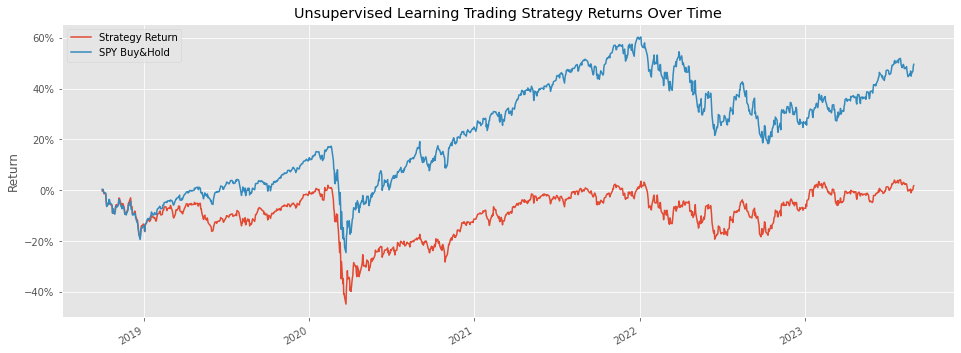

In [63]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()